In [14]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base
from feature_engineering.stage2 import generate_2nd_stage_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ensemble"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ensemble']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

exp_084


In [2]:
oof_2nd = pd.read_csv(f'/kaggle/output/{CFG["2nd_stage"]["execution"]["best_exp_id"]}/oof.csv')
oof_2nd.head()

,series_id,step,score,event
0,038441c925bb,4739,-0.047600,wakeup
1,038441c925bb,4739,1.529368,onset
2,038441c925bb,4763,-0.018053,wakeup
3,038441c925bb,4763,1.715143,onset
4,038441c925bb,4787,-0.000116,wakeup


In [3]:
oof_gru = pd.read_csv(f'/kaggle/output/{CFG["gru"]["execution"]["best_exp_id"]}/oof.csv')
oof_gru.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,0,0.043447,-0.017455
1,05e1944c3818,1,0.061952,-0.019444
2,05e1944c3818,2,0.064383,-0.013300
3,05e1944c3818,3,0.064990,-0.008018
4,05e1944c3818,4,0.065119,-0.004213


In [16]:
wakeup_2nd = oof_2nd[oof_2nd["event"]=="wakeup"]
onset_2nd = oof_2nd[oof_2nd["event"]=="onset"]
dfs = []
for seires_id, df in tqdm(oof_gru.groupby("series_id")):
    df2 = wakeup_2nd[wakeup_2nd["series_id"]==seires_id]
    df["wakeup_oof_2nd"] = df["step"].map(df2.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df2 = onset_2nd[onset_2nd["series_id"]==seires_id]
    df["onset_oof_2nd"] = df["step"].map(df2.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    df["wakeup_oof"] = df["wakeup_oof_2nd"] * 0.5 + df["wakeup_oof"] * 0.5
    df["onset_oof"] = df["onset_oof_2nd"] * 0.5 + df["onset_oof"] * 0.5
    df = df[["series_id", "step", "wakeup_oof", "onset_oof"]].reset_index(drop=True)
    dfs.append(df)
oof_df = pd.concat(dfs)
del dfs
gc.collect()

100%|██████████| 277/277 [01:09<00:00,  4.00it/s]


979

14293673

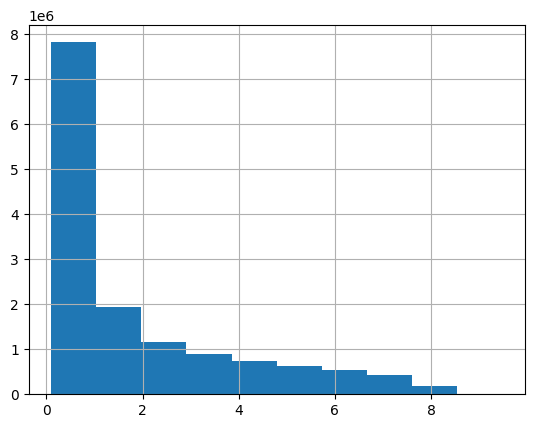

In [17]:
dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.1]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.1]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["score"].hist()
len(train)

In [19]:
from multiprocessing import Pool

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:24<00:00, 11.48it/s]


In [20]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.7427


event   tolerance
onset   12           0.189665
        36           0.587040
        60           0.732712
        90           0.800017
        120          0.822552
        150          0.834297
        180          0.843289
        240          0.852361
        300          0.858073
        360          0.864167
wakeup  12           0.187116
        36           0.607604
        60           0.741705
        90           0.804003
        120          0.827287
        150          0.837461
        180          0.849865
        240          0.860168
        300          0.873165
        360          0.880852
dtype: float64